Total samples: 3015
Original Classes: ['Cat', 'Cat2', 'Dog', 'Dog2']
Unified Class Labels: {0, 1}
Number of training samples: 2412
Number of validation samples: 301
Number of testing samples: 302


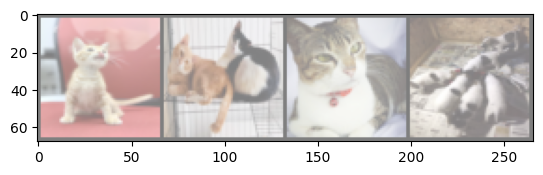

Sample Labels: [0, 0, 0, 1]


In [20]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),       
])

dataset = ImageFolder(root='../Dog_Cat/dataset2', transform=transform)  # 먼저 dataset 생성

class_names = dataset.classes  # ['Cat', 'Cat2', 'Dog', 'Dog2']
class_mapping = {name: 0 if 'Cat' in name else 1 for name in class_names}  # Cat, Cat2 → 0 / Dog, Dog2 → 1

def target_transform(label):
    return class_mapping[class_names[label]]

dataset = ImageFolder(root='../Dog_Cat/dataset2', transform=transform, target_transform=target_transform)
print(f"Total samples: {len(dataset)}")

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


print(f"Original Classes: {class_names}")  # 원본 클래스
print(f"Unified Class Labels: {set([label for _, label in dataset])}")  # 변환된 라벨 값
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of testing samples: {len(test_data)}")

def imshow(img):
    img = img / 2 + 0.5  # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))  # 첫 4개 이미지 출력
print(f"Sample Labels: {labels[:4].tolist()}")  # 샘플 이미지의 실제 라벨 출력

In [21]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")

TypeError: __init__() missing 1 required positional argument: 'num_classes'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 클래스 이름 정의 (올바르게 접근)
class_names = train_loader.dataset.dataset.classes  

# 모델 예측값을 시각적으로 확인하는 함수
def imshow(img, ax, title):
    img = img / 2 + 0.5  # 정규화 되돌리기
    npimg = img.cpu().numpy()  # NumPy 배열 변환
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # 차원 변환 (C, H, W) -> (H, W, C)
    ax.set_title(title, fontsize=12)  # 예측 결과를 제목으로 표시
    ax.axis("off")  # 축 숨기기

# 일부 테스트 샘플 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# 모델 예측 수행
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # 가장 높은 확률의 클래스 선택

# 이미지 및 예측 결과 출력
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # 2x5 레이아웃으로 이미지 배치
fig.suptitle("Model Predictions", fontsize=16)  # 전체 제목 설정

for i, ax in enumerate(axes.flat):
    if i < len(images):
        imshow(images[i], ax, f"Pred: {class_names[predicted[i].item()]}\nTrue: {class_names[labels[i].item()]}")

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # 제목과 이미지 간격 조정
plt.show()